In [167]:
# %pip install matplotlib numpy opencv-python Pillow moviepy

In [168]:
# %pip freeze

In [169]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [170]:
def list_images(images, cols = 2, rows = 5, cmap=None):
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

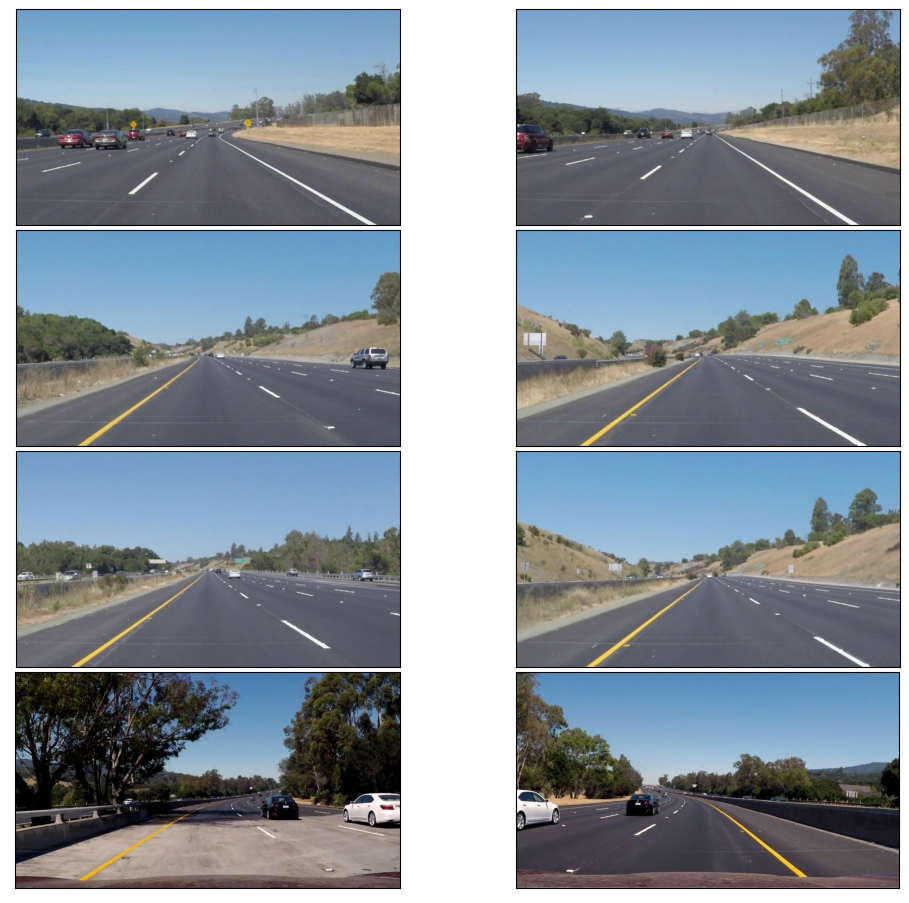

In [171]:
# test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

In [172]:
test_images[0].shape

(540, 960, 3)

In [173]:
# Based on RGB color section (white and yellow lines)
def RGB_color_selection(image):
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

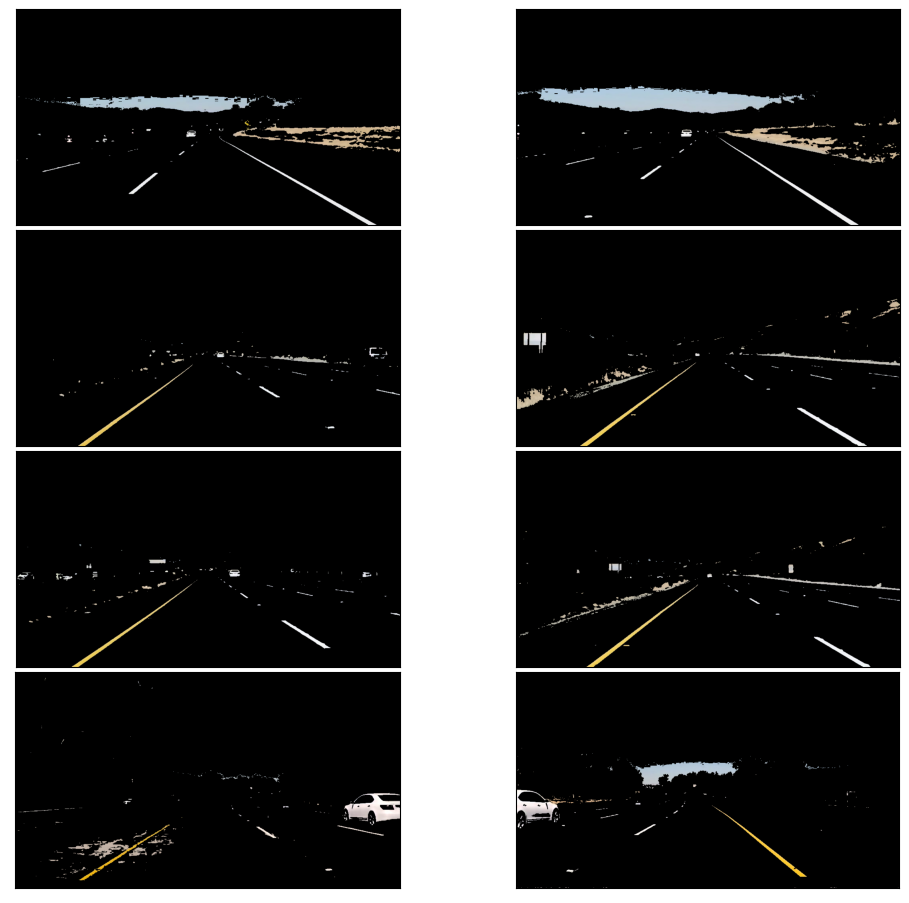

In [174]:
list_images(list(map(RGB_color_selection, test_images)))

In [175]:
# convering rgb to hsv
def convert_hsv(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# list_images(list(map(convert_hsv, test_images)))

In [176]:
# color selection using hsv
def HSV_color_selection(image):
    converted_image = convert_hsv(image)
    
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [177]:
# list_images(list(map(HSV_color_selection, test_images)))

In [178]:
def convert_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# list_images(list(map(convert_hsl, test_images)))

In [179]:
def HSL_color_selection(image):
    converted_image = convert_hsl(image)
    
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [180]:
# list_images(list(map(HSL_color_selection, test_images)))

In [181]:
color_selected_images = list(map(HSL_color_selection, test_images))

In [182]:
# Image to grey scale image
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [183]:
gray_images = list(map(gray_scale, color_selected_images))
# list_images(gray_images)

In [184]:
# Smoothing of image
def gaussian_smoothing(image, kernel_size = 13):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)   

In [185]:
blur_images = list(map(gaussian_smoothing, gray_images))
# list_images(blur_images)

In [186]:
# Using canny edge detection to detect edges of road
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    return cv2.Canny(image, low_threshold, high_threshold)

In [187]:
edge_detected_images = list(map(canny_detector, gray_images))
# list_images(edge_detected_images)

In [188]:
# Masking reagion of interest
def region_selection(image):
    mask = np.zeros_like(image)   
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    # bottom_left  = [cols * 0.1, rows * 0.95]
    # top_left     = [cols * 0.4, rows * 0.6]
    # bottom_right = [cols * 0.9, rows * 0.95]
    # top_right    = [cols * 0.6, rows * 0.6]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [189]:
masked_image = list(map(region_selection, edge_detected_images))
# list_images(masked_image)

In [190]:
# import imutils
# masked_image[6] = imutils.rotate(masked_image[6], angle=15)
# test_images[6] = imutils.rotate(test_images[6], angle=15)

In [191]:
# Mapping lines using haugh transform
def hough_transform(image):
    rho = 1
    theta = np.pi/180
    threshold = 30
    minLineLength = 50
    maxLineGap = 300
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [192]:
hough_lines = list(map(hough_transform, masked_image))

In [193]:
# img = masked_image[7]

In [194]:
# list_images([img])

In [195]:
# Drawing lines on the image
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

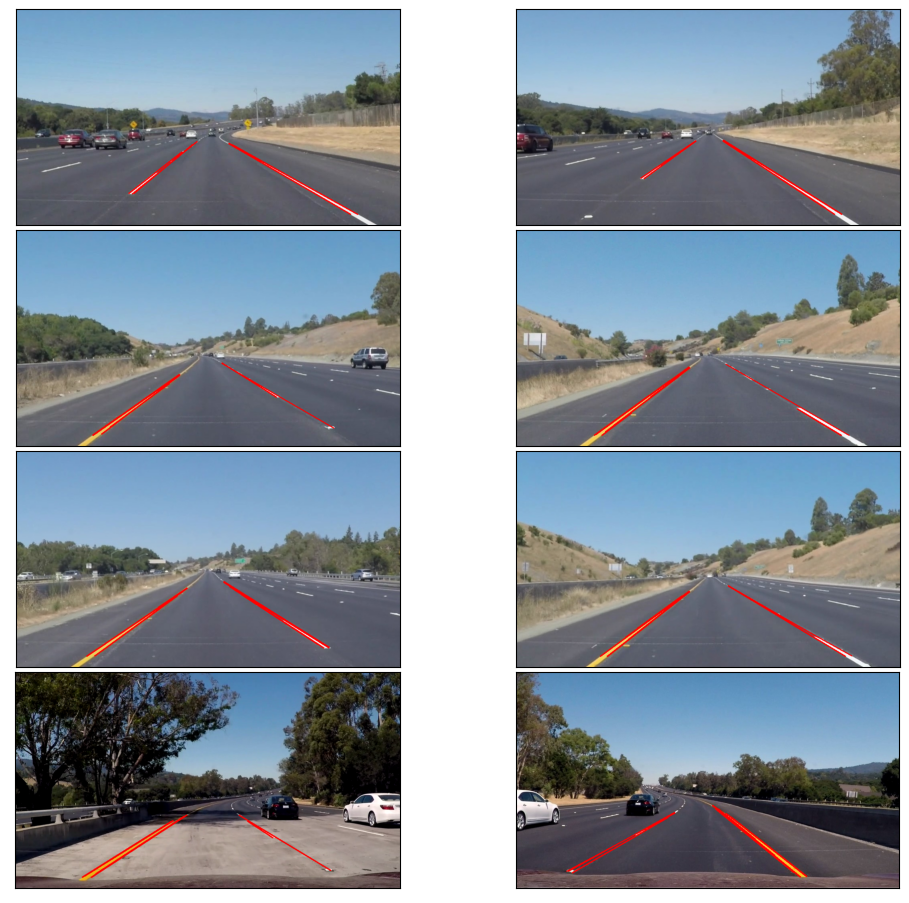

In [196]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [197]:
def map_coordinates(frame, parameters):
    
    height, width, _ = frame.shape
    slope, intercept = parameters
    
    if slope == 0:
        slope = 0.1
    
    y1 = height
    y2 = int(height*0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return [[x1, y1, x2, y2]]

In [198]:
# Otimizing the line by joining and streaching them
def optimize_lines(frame, lines):
    height, width, _ = frame.shape
    
    if lines is not None:
        lane_lines = []
        left_fit = []
        right_fit = []        
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)

            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            
            if slope < 0:
                left_fit.append((slope, intercept))
            else:   
                right_fit.append((slope, intercept))

        if len(left_fit) > 0:
            left_fit_average = np.average(left_fit, axis=0)
            lane_lines.append(map_coordinates(frame, left_fit_average))
            
        if len(right_fit) > 0:
            right_fit_average = np.average(right_fit, axis=0)
            lane_lines.append(map_coordinates(frame, right_fit_average))
        
    return lane_lines

In [199]:
opt_lines = []
for image, lines in zip(test_images, hough_lines):
    opt_lines.append(optimize_lines(image, lines))

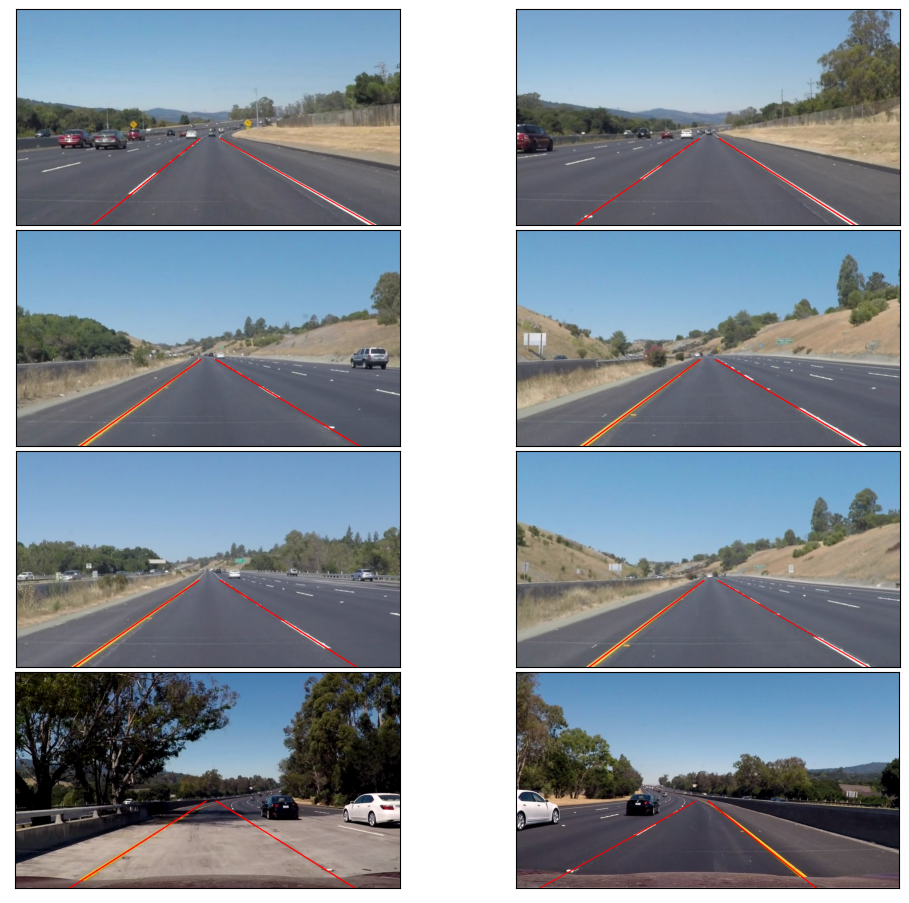

In [200]:
line_images = []
for image, lines in zip(test_images, opt_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [201]:
# Center of lines on the image
def get_floating_center(frame, lane_lines):
    
    height, width, _ = frame.shape
    
    if len(lane_lines) == 2:
        left_x1, _, left_x2, _ = lane_lines[0][0]
        right_x1, _, right_x2, _ = lane_lines[1][0]
        
        low_mid = (right_x1 + left_x1) / 2
        up_mid = (right_x2 + left_x2) / 2

    else:
        up_mid = int(width*1.9)
        low_mid = int(width*1.9)
    
    return up_mid, low_mid

In [226]:
# Getting the deviation by comparing the center point of actual line and the detected lines in the projection (based on the distribution of white lines)
def add_text(frame, image_center, left_x_base, right_x_base):

    lane_center = left_x_base + (right_x_base - left_x_base) / 2
    
    deviation = image_center - lane_center

    if deviation >= 108:
        text = "Straight"
    elif deviation <= 108 and deviation >= 94:
        text = "Left"
    elif deviation <= 94:
        text = "Right"
    print(deviation, image_center, lane_center, text)
    
    cv2.putText(frame, "Final: " + text, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    return frame

In [227]:
# Generating the histogram to measure the lane lines
def histogram(frame):
    
    histogram = np.sum(frame, axis=0)   
    midpoint = np.int(histogram.shape[0]/2)    
    
    left_x_base = np.argmax(histogram[:midpoint])
    
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_x_base, right_x_base

In [228]:
# Calculating the region of interest for getting the lines
# def op():
#     height, width = image.shape[:2]
#     source_points = np.float32([[int(width*0.4), int(height*0.6)],
#                       [int(width*0.6), int(height*0.6)],
#                       [int(width*0.1), height*0.95],
#                       [int(width*0.9), height*0.95]])
#     print(source_points)
# op()

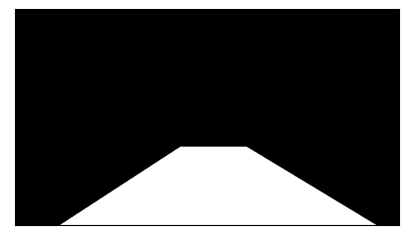

In [229]:
mm = np.zeros_like(test_images[0])
height, width = test_images[0].shape[:2]
sp = np.array([ [412.5, 345],
                        [112.5, height],
                        [900, height],
                        [577.5, 345]], dtype=np.int32)
cv2.fillPoly(mm, np.int32([sp]), (255,) * (test_images[0].shape[2]))
list_images([mm])

In [230]:
# Changing the prespective of the region of interst got get the top view
def warp_perspective(frame):
    height, width = image.shape[:2]

    
    # (1280, 720)
    # self.src = np.float32([(550, 460),     # top-left
    #                            (150, 720),     # bottom-left
    #                            (1200, 720),    # bottom-right
    #                            (770, 460)])    # top-right
    #     self.dst = np.float32([(100, 0),
    #                            (100, 720),
    #                            (1100, 720),
    #                            (1100, 0)])

    # # (960, 540)
    # source_points = np.float32(
    #                   [
    #                     [412.5, 345],
    #                     [112.5, height],
    #                     [900, height],
    #                     [577.5, 345],
    #                 ]
    #               )
    
    source_points = np.float32(
                      [
                        [425, 330],
                        [112.5, height],
                        [900, height],
                        [565, 330],
                    ]
                  )


    # (960, 540)
    # source_points = np.float32(
    #                   [
    #                     [width*0.465, int(height*0.6)],
    #                     [int(width*0.1), height*0.99],
    #                     [int(width*0.9), height*0.99],
    #                     [width*0.535, int(height*0.6)],
    #                 ]
    #               )


    # source_points = np.float32(
    #                   [[450, 318],
    #                   [498, 318],
    #                   [162, 533],
    #                   [850, 533]]
    #                   )
    
    # destination_points = np.float32([[0, 0],
    #                   [width, 0],
    #                   [0, height],
    #                   [width, height]])
    offset = 50
    # offset = 100
    destination_points = np.float32([[offset, 0],
                      [offset, height],
                      [width-2*offset, height],
                      [width-2*offset, 0]])
    # source_points = np.float32(
    #     [[273,680],
    #      [1046,680],
    #      [585,455],
    #      [700,455]])

    # destination_points = np.float32(
    #     [[300,720],
    #      [980,720],
    #      [300,0],
    #      [980,0]])
    # source_points = np.float32([(580, 460), (205, 720), (1110, 720), (703, 460)])
    # destination_points = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
    
    matrix = cv2.getPerspectiveTransform(source_points, destination_points) 
    
    skyview = cv2.warpPerspective(frame, matrix, (width, height))    

    return skyview

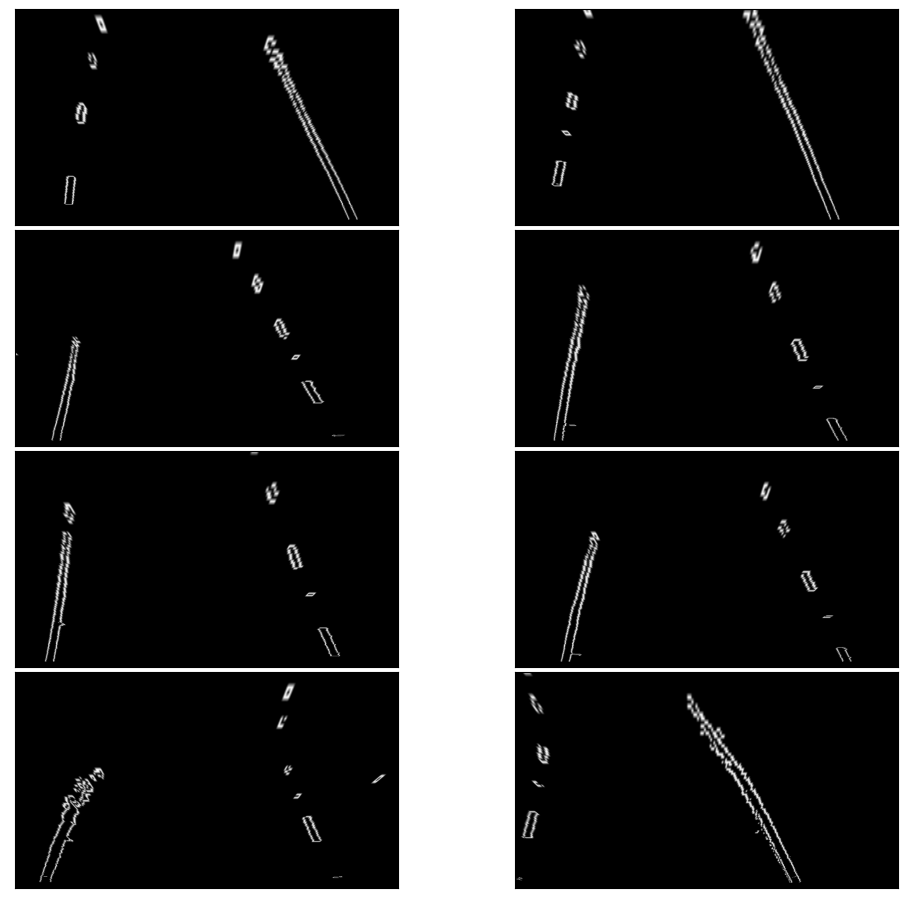

In [231]:
tt = []
for mi in masked_image:
  im = warp_perspective(mi)
  tt.append(im)
list_images(tt)

In [232]:
# len(test_images), len(opt_lines), len(line_images), len(masked_image)

144.5 542.0 397.5 Straight
112.5 496.5 384.0 Straight
132.5 508.0 375.5 Straight
134.5 515.0 380.5 Straight
109.0 496.5 387.5 Straight
132.0 530.0 398.0 Straight
75.5 490.0 414.5 Right
97.0 404.5 307.5 Left


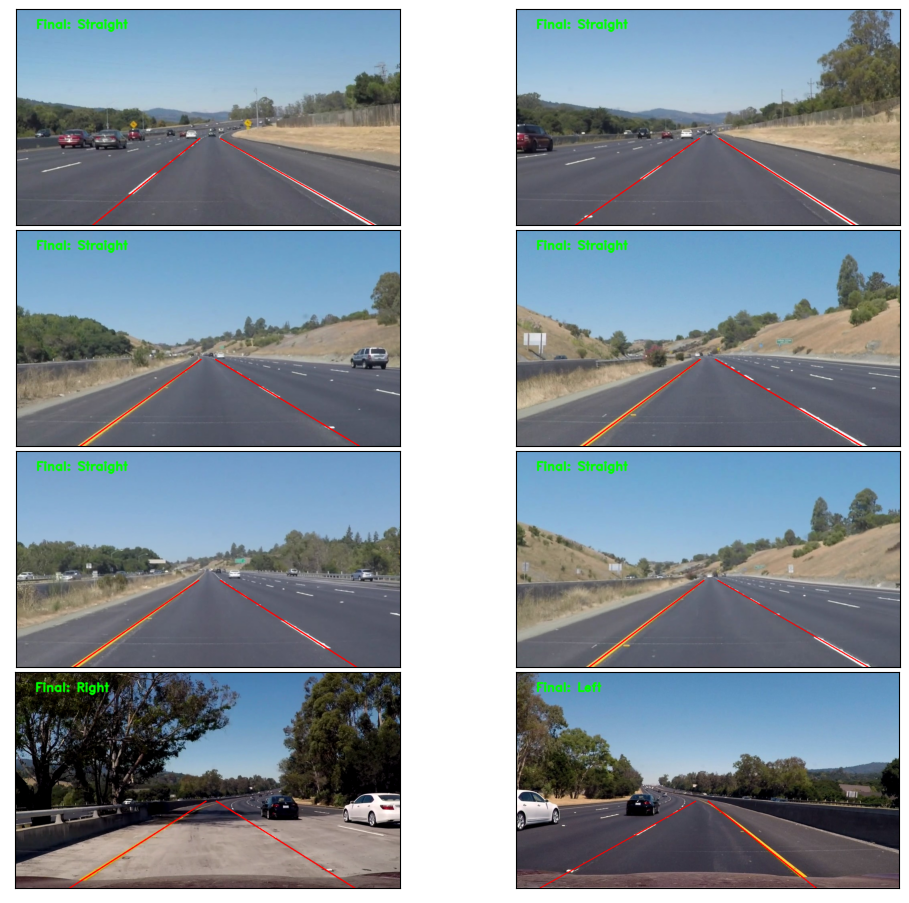

'\nstraight   \nstraight\nstraight \nstraight\nstraight \nstraight\nright \nleft\n'

In [233]:
temp = []
it = []
for image, lines, op_frame, mi in zip(test_images, opt_lines, line_images, masked_image):
  im = warp_perspective(mi)
  it.append(im)
  left_x_base, right_x_base = histogram(im)
  _, low_center = get_floating_center(image, lines)
  final_frame = add_text(op_frame, low_center, left_x_base, right_x_base)
  temp.append(final_frame)
# list_images(it)
list_images(temp)
"""
straight   
straight
straight 
straight
straight 
straight
right 
left
"""

In [234]:
def frame_processing(image):
    # global frame_no
    # print(frame_no)
    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    masked_image       = region_selection(edges)
    # list_images([masked_image])
    hough_line = hough_transform(masked_image)
    opt_line = optimize_lines(image, hough_line)
    line_image = draw_lines(image, opt_line)
    im = warp_perspective(masked_image)
    # list_images([im])
    left_x_base, right_x_base = histogram(im)
    _, low_center = get_floating_center(image, opt_line)
    final_frame = add_text(line_image, low_center, left_x_base, right_x_base)
    # frame_no += 1
    return final_frame

In [235]:

def process_video(test_video, output_video):
    input_video =  VideoFileClip(os.path.join('test_videos', test_video), audio=False)
    processed = input_video.fl_image(frame_processing)
    processed.write_videofile(os.path.join('op_videos', output_video), audio=False)

In [237]:
%time process_video('solidYellowLeft.mp4', 'op3.mp4')

47.0 469.0 422.0 Right
Moviepy - Building video op_videos\op3.mp4.
Moviepy - Writing video op_videos\op3.mp4



t:   0%|          | 3/681 [00:00<00:22, 29.60it/s, now=None]

47.0 469.0 422.0 Right
83.5 470.5 387.0 Right
72.0 472.5 400.5 Right
87.0 478.5 391.5 Right
91.0 483.0 392.0 Right


t:   1%|          | 8/681 [00:00<00:17, 39.49it/s, now=None]

72.5 482.0 409.5 Right
81.5 481.0 399.5 Right


t:   2%|▏         | 13/681 [00:00<00:15, 42.28it/s, now=None]

67.0 482.0 415.0 Right
79.5 483.0 403.5 Right
70.5 488.0 417.5 Right
76.5 493.0 416.5 Right
69.5 488.0 418.5 Right
100.0 489.0 389.0 Left
88.0 492.0 404.0 Right


t:   3%|▎         | 18/681 [00:00<00:15, 42.14it/s, now=None]

88.5 496.0 407.5 Right
91.5 499.0 407.5 Right
84.5 497.0 412.5 Right
88.0 500.0 412.0 Right
87.5 500.5 413.0 Right
85.5 502.0 416.5 Right
82.0 500.5 418.5 Right
83.5 502.0 418.5 Right


t:   3%|▎         | 23/681 [00:00<00:16, 39.04it/s, now=None]

95.5 502.0 406.5 Left
95.5 495.5 400.0 Left


t:   4%|▍         | 27/681 [00:00<00:20, 32.53it/s, now=None]

95.5 499.0 403.5 Left
97.5 501.5 404.0 Left
98.5 506.5 408.0 Left
100.0 509.5 409.5 Left
98.0 511.0 413.0 Left


t:   5%|▍         | 31/681 [00:00<00:24, 26.46it/s, now=None]

85.0 500.5 415.5 Right
85.5 504.5 419.0 Right
106.5 511.5 405.0 Left


t:   5%|▍         | 34/681 [00:01<00:24, 26.94it/s, now=None]

85.0 507.5 422.5 Right
91.5 515.0 423.5 Right
88.5 513.5 425.0 Right
87.0 513.0 426.0 Right


t:   6%|▌         | 39/681 [00:01<00:20, 30.88it/s, now=None]

84.0 512.0 428.0 Right
88.5 516.0 427.5 Right
86.5 515.5 429.0 Right
108.5 514.5 406.0 Straight
109.0 515.5 406.5 Straight


t:   6%|▋         | 44/681 [00:01<00:18, 33.69it/s, now=None]

105.0 512.0 407.0 Left
99.0 506.5 407.5 Left
107.0 513.0 406.0 Left
100.0 507.5 407.5 Left
98.0 507.0 409.0 Left
112.5 507.5 395.0 Straight


t:   7%|▋         | 48/681 [00:01<00:20, 30.59it/s, now=None]

114.5 510.5 396.0 Straight
98.0 511.0 413.0 Left
122.0 510.5 388.5 Straight


t:   8%|▊         | 52/681 [00:01<00:20, 30.94it/s, now=None]

137.0 511.0 374.0 Straight
120.0 512.5 392.5 Straight
131.5 507.5 376.0 Straight


t:   8%|▊         | 56/681 [00:01<00:20, 30.34it/s, now=None]

119.5 513.5 394.0 Straight
127.5 507.5 380.0 Straight
110.5 507.5 397.0 Straight
107.5 505.5 398.0 Left


t:   9%|▉         | 60/681 [00:01<00:20, 30.89it/s, now=None]

111.5 512.0 400.5 Straight
103.5 505.0 401.5 Left
115.5 505.5 390.0 Straight


t:   9%|▉         | 64/681 [00:02<00:20, 30.74it/s, now=None]

100.0 505.5 405.5 Left
120.5 504.0 383.5 Straight
123.0 505.5 382.5 Straight
120.0 505.0 385.0 Straight


t:  10%|▉         | 68/681 [00:02<00:19, 31.63it/s, now=None]

130.5 504.5 374.0 Straight
118.0 506.5 388.5 Straight
129.0 506.5 377.5 Straight


t:  11%|█         | 72/681 [00:02<00:18, 33.00it/s, now=None]

119.5 501.0 381.5 Straight
118.0 501.0 383.0 Straight
113.5 499.0 385.5 Straight
99.0 501.0 402.0 Left
111.0 500.0 389.0 Straight
97.0 502.0 405.0 Left
90.5 499.5 409.0 Right
90.5 499.5 409.0 Right


t:  12%|█▏        | 80/681 [00:02<00:17, 35.12it/s, now=None]

115.0 500.5 385.5 Straight
113.5 498.0 384.5 Straight
125.5 500.0 374.5 Straight
112.0 500.0 388.0 Straight
118.5 494.0 375.5 Straight


t:  12%|█▏        | 84/681 [00:02<00:16, 36.06it/s, now=None]

114.5 493.0 378.5 Straight
102.5 496.5 394.0 Left
116.0 497.0 381.0 Straight


t:  13%|█▎        | 88/681 [00:02<00:16, 35.46it/s, now=None]

99.5 495.0 395.5 Left
96.0 493.5 397.5 Left
105.5 490.0 384.5 Left
89.5 492.0 402.5 Right


t:  14%|█▎        | 93/681 [00:02<00:15, 37.31it/s, now=None]

104.5 495.0 390.5 Left
114.5 492.5 378.0 Straight
112.0 493.5 381.5 Straight
104.5 493.5 389.0 Left
104.5 495.0 390.5 Left
95.0 488.0 393.0 Left
107.5 489.0 381.5 Left
96.5 493.0 396.5 Left
89.0 489.5 400.5 Right


t:  14%|█▍        | 98/681 [00:02<00:15, 38.65it/s, now=None]

104.0 493.0 389.0 Left
84.5 490.5 406.0 Right
94.0 489.0 395.0 Left
107.0 489.5 382.5 Left
122.5 495.5 373.0 Straight
118.5 495.0 376.5 Straight


t:  15%|█▌        | 103/681 [00:03<00:14, 39.88it/s, now=None]

102.5 493.5 391.0 Left
101.5 493.5 392.0 Left
114.0 495.0 381.0 Straight


t:  16%|█▌        | 107/681 [00:03<00:14, 39.49it/s, now=None]

97.0 493.5 396.5 Left
110.5 495.5 385.0 Straight
97.5 496.5 399.0 Left
89.0 492.5 403.5 Right
90.5 494.0 403.5 Right
85.5 494.0 408.5 Right


t:  16%|█▋        | 112/681 [00:03<00:14, 40.31it/s, now=None]

87.0 496.5 409.5 Right
125.0 499.0 374.0 Straight
122.0 498.0 376.0 Straight


t:  17%|█▋        | 117/681 [00:03<00:14, 39.86it/s, now=None]

119.5 497.0 377.5 Straight
99.0 495.0 396.0 Left
95.5 494.0 398.5 Left
95.5 496.0 400.5 Left
107.5 497.5 390.0 Left


t:  18%|█▊        | 122/681 [00:03<00:13, 40.19it/s, now=None]

88.0 493.5 405.5 Right
103.5 497.5 394.0 Left
101.5 498.5 397.0 Left


t:  19%|█▊        | 127/681 [00:03<00:14, 39.00it/s, now=None]

88.0 498.5 410.5 Right
104.0 498.5 394.5 Left
104.0 499.5 395.5 Left
103.5 498.0 394.5 Left
101.0 498.0 397.0 Left


t:  19%|█▉        | 131/681 [00:03<00:14, 38.78it/s, now=None]

97.5 499.0 401.5 Left
99.0 501.5 402.5 Left
108.0 498.5 390.5 Straight


t:  20%|█▉        | 136/681 [00:03<00:13, 40.03it/s, now=None]

94.0 498.0 404.0 Left
104.5 500.5 396.0 Left
98.0 496.5 398.5 Left
86.5 497.0 410.5 Right
92.5 504.5 412.0 Right
84.5 498.0 413.5 Right
83.0 501.0 418.0 Right
101.0 498.0 397.0 Left


t:  21%|██        | 141/681 [00:03<00:13, 40.21it/s, now=None]

104.5 502.0 397.5 Left
118.5 502.0 383.5 Straight
98.0 497.5 399.5 Left
112.5 498.5 386.0 Straight
95.5 497.0 401.5 Left


t:  21%|██▏       | 146/681 [00:04<00:13, 40.85it/s, now=None]

100.0 504.5 404.5 Left
94.5 501.0 406.5 Left
105.5 499.0 393.5 Left
103.5 500.5 397.0 Left
103.5 502.0 398.5 Left
101.0 500.5 399.5 Left
82.0 500.5 418.5 Right


t:  23%|██▎       | 155/681 [00:04<00:14, 36.26it/s, now=None]

111.0 504.5 393.5 Straight
118.5 503.0 384.5 Straight
101.0 503.0 402.0 Left
103.0 508.0 405.0 Left
82.5 505.0 422.5 Right
112.5 510.5 398.0 Straight
84.5 509.0 424.5 Right


t:  23%|██▎       | 159/681 [00:04<00:14, 35.33it/s, now=None]

83.5 512.5 429.0 Right
79.0 510.0 431.0 Right
75.5 509.0 433.5 Right
74.5 512.5 438.0 Right
83.5 512.5 429.0 Right


t:  24%|██▍       | 163/681 [00:04<00:15, 33.17it/s, now=None]

70.0 514.0 444.0 Right
67.0 515.5 448.5 Right


t:  25%|██▍       | 167/681 [00:04<00:16, 31.49it/s, now=None]

106.5 515.0 408.5 Left
109.0 517.0 408.0 Straight
105.0 518.5 413.5 Left
89.5 518.5 429.0 Right


t:  25%|██▌       | 171/681 [00:04<00:15, 32.98it/s, now=None]

105.0 523.5 418.5 Left
83.5 518.5 435.0 Right
83.0 521.5 438.5 Right


t:  26%|██▌       | 175/681 [00:05<00:17, 29.47it/s, now=None]

80.0 522.0 442.0 Right
79.5 522.5 443.0 Right
95.0 525.0 430.0 Left
88.5 524.5 436.0 Right
118.0 526.0 408.0 Straight
72.5 528.0 455.5 Right


t:  26%|██▋       | 179/681 [00:05<00:16, 30.78it/s, now=None]

103.0 531.0 428.0 Left
119.0 530.0 411.0 Straight
116.0 532.0 416.0 Straight
122.0 542.0 420.0 Straight
103.0 537.5 434.5 Left


t:  27%|██▋       | 183/681 [00:05<00:15, 31.86it/s, now=None]

110.5 544.0 433.5 Straight
100.5 537.0 436.5 Left
100.5 539.0 438.5 Left


t:  27%|██▋       | 187/681 [00:05<00:15, 31.01it/s, now=None]

98.5 536.0 437.5 Left
94.5 535.0 440.5 Left
93.0 535.0 442.0 Right
96.0 536.5 440.5 Left


t:  28%|██▊       | 192/681 [00:05<00:14, 34.05it/s, now=None]

95.0 536.5 441.5 Left
135.5 532.5 397.0 Straight
130.0 541.0 411.0 Straight
122.0 536.0 414.0 Straight


t:  29%|██▉       | 196/681 [00:05<00:15, 32.05it/s, now=None]

135.5 535.0 399.5 Straight
122.0 536.5 414.5 Straight
126.5 531.0 404.5 Straight


t:  29%|██▉       | 200/681 [00:05<00:14, 32.99it/s, now=None]

115.5 530.5 415.0 Straight
125.5 529.0 403.5 Straight
119.0 532.0 413.0 Straight
102.0 528.5 426.5 Left
102.0 532.5 430.5 Left


t:  30%|██▉       | 204/681 [00:05<00:14, 34.06it/s, now=None]

116.5 532.0 415.5 Straight
134.0 527.5 393.5 Straight


t:  31%|███       | 208/681 [00:06<00:15, 30.42it/s, now=None]

140.0 526.0 386.0 Straight
139.5 522.5 383.0 Straight
120.5 525.5 405.0 Straight
117.5 525.5 408.0 Straight
129.0 524.0 395.0 Straight
121.0 522.5 401.5 Straight


t:  31%|███       | 212/681 [00:06<00:14, 31.51it/s, now=None]

119.0 520.5 401.5 Straight
115.5 519.5 404.0 Straight
110.5 516.0 405.5 Straight
130.5 514.5 384.0 Straight


t:  32%|███▏      | 216/681 [00:06<00:15, 30.18it/s, now=None]

131.0 515.0 384.0 Straight
137.5 512.0 374.5 Straight
123.5 511.0 387.5 Straight
136.5 512.5 376.0 Straight


t:  32%|███▏      | 220/681 [00:06<00:17, 26.46it/s, now=None]

134.0 512.5 378.5 Straight
135.5 516.5 381.0 Straight
128.0 514.0 386.0 Straight
104.5 502.0 397.5 Left
114.0 505.5 391.5 Straight


t:  33%|███▎      | 224/681 [00:06<00:16, 28.11it/s, now=None]

113.0 507.5 394.5 Straight
95.5 509.5 414.0 Left


t:  33%|███▎      | 227/681 [00:06<00:16, 28.25it/s, now=None]

97.0 513.0 416.0 Left
91.5 510.5 419.0 Right
86.0 507.0 421.0 Right
85.0 511.0 426.0 Right
96.5 512.5 416.0 Left


t:  34%|███▍      | 231/681 [00:06<00:15, 29.81it/s, now=None]

87.5 509.0 421.5 Right
121.5 504.5 383.0 Straight


t:  35%|███▍      | 235/681 [00:07<00:15, 28.76it/s, now=None]

122.0 506.5 384.5 Straight
107.0 507.0 400.0 Left
103.5 506.0 402.5 Left
115.5 507.5 392.0 Straight
92.5 503.5 411.0 Right
106.5 503.0 396.5 Left
104.0 507.5 403.5 Left


t:  35%|███▌      | 239/681 [00:07<00:14, 29.70it/s, now=None]

101.5 505.0 403.5 Left
100.5 506.5 406.0 Left
91.5 505.0 413.5 Right
115.0 509.5 394.5 Straight


t:  36%|███▌      | 243/681 [00:07<00:14, 30.49it/s, now=None]

117.0 510.0 393.0 Straight
135.0 519.0 384.0 Straight
123.0 507.5 384.5 Straight


t:  36%|███▋      | 247/681 [00:07<00:14, 30.16it/s, now=None]

121.0 507.5 386.5 Straight
116.5 505.5 389.0 Straight
106.0 509.0 403.0 Left


t:  37%|███▋      | 251/681 [00:07<00:14, 30.29it/s, now=None]

118.0 511.0 393.0 Straight
114.5 511.0 396.5 Straight
100.5 507.5 407.0 Left
93.5 505.5 412.0 Right


t:  37%|███▋      | 255/681 [00:07<00:14, 28.57it/s, now=None]

93.0 507.5 414.5 Right
121.0 507.0 386.0 Straight


t:  38%|███▊      | 259/681 [00:07<00:14, 29.65it/s, now=None]

117.0 506.0 389.0 Straight
115.0 505.5 390.5 Straight
115.0 506.0 391.0 Straight
113.0 508.5 395.5 Straight
119.5 507.0 387.5 Straight
100.0 504.0 404.0 Left
106.0 512.0 406.0 Left


t:  39%|███▉      | 265/681 [00:08<00:15, 27.72it/s, now=None]

116.5 510.5 394.0 Straight
100.5 510.5 410.0 Left
86.5 504.5 418.0 Right
90.5 509.5 419.0 Right
85.0 508.0 423.0 Right
127.5 508.5 381.0 Straight


t:  40%|███▉      | 272/681 [00:08<00:14, 28.81it/s, now=None]

107.0 506.5 399.5 Left
123.0 509.0 386.0 Straight
107.0 509.0 402.0 Left
119.5 514.0 394.5 Straight
118.5 516.0 397.5 Straight
116.5 517.0 400.5 Straight
110.5 516.0 405.5 Straight


t:  41%|████      | 278/681 [00:08<00:14, 28.64it/s, now=None]

108.0 512.5 404.5 Straight
56.0 516.0 460.0 Right
51.0 514.5 463.5 Right
91.5 515.0 423.5 Right
125.5 512.0 386.5 Straight
135.0 512.5 377.5 Straight


t:  42%|████▏     | 284/681 [00:08<00:16, 24.53it/s, now=None]

140.5 513.5 373.0 Straight
146.0 523.5 377.5 Straight
134.5 519.0 384.5 Straight
136.5 521.0 384.5 Straight
129.5 515.5 386.0 Straight


t:  42%|████▏     | 287/681 [00:08<00:16, 24.51it/s, now=None]

132.0 517.5 385.5 Straight
135.5 538.5 403.0 Straight
102.5 491.5 389.0 Left
129.5 519.0 389.5 Straight


t:  43%|████▎     | 291/681 [00:09<00:14, 27.38it/s, now=None]

102.0 501.5 399.5 Left
132.5 505.0 372.5 Straight
123.5 509.0 385.5 Straight


t:  43%|████▎     | 295/681 [00:09<00:13, 29.34it/s, now=None]

116.0 510.0 394.0 Straight
111.5 507.5 396.0 Straight
132.0 520.0 388.0 Straight
113.0 515.0 402.0 Straight


t:  44%|████▍     | 298/681 [00:09<00:14, 26.10it/s, now=None]

101.5 506.5 405.0 Left


t:  44%|████▍     | 302/681 [00:09<00:13, 28.04it/s, now=None]

101.0 506.5 405.5 Left
108.0 507.5 399.5 Straight
102.0 513.0 411.0 Left
107.5 513.0 405.5 Left
136.5 511.0 374.5 Straight
96.0 508.5 412.5 Left


t:  45%|████▌     | 309/681 [00:09<00:13, 26.96it/s, now=None]

120.5 509.5 389.0 Straight
124.5 504.5 380.0 Straight
119.5 502.5 383.0 Straight
120.0 506.0 386.0 Straight
108.5 510.5 402.0 Straight


t:  46%|████▌     | 313/681 [00:09<00:12, 28.35it/s, now=None]

101.0 504.0 403.0 Left
99.0 505.5 406.5 Left
108.5 502.0 393.5 Straight
113.0 508.5 395.5 Straight
94.5 506.0 411.5 Left
91.0 505.0 414.0 Right


t:  47%|████▋     | 319/681 [00:10<00:13, 26.80it/s, now=None]

135.0 505.0 370.0 Straight
135.5 507.0 371.5 Straight
118.5 505.0 386.5 Straight
132.0 506.5 374.5 Straight
129.0 505.0 376.0 Straight
129.0 508.0 379.0 Straight
117.0 511.0 394.0 Straight


t:  48%|████▊     | 327/681 [00:10<00:11, 30.07it/s, now=None]

129.5 513.0 383.5 Straight
112.5 508.5 396.0 Straight
108.0 509.0 401.0 Straight
116.0 508.0 392.0 Straight
109.5 506.5 397.0 Straight
143.0 506.5 363.5 Straight
127.5 504.5 377.0 Straight


t:  49%|████▉     | 335/681 [00:10<00:11, 31.29it/s, now=None]

141.5 506.0 364.5 Straight
130.5 508.0 377.5 Straight
136.5 509.0 372.5 Straight
128.0 503.0 375.0 Straight
112.5 503.5 391.0 Straight
106.0 498.5 392.5 Left
123.0 505.0 382.0 Straight


t:  50%|████▉     | 339/681 [00:10<00:11, 29.03it/s, now=None]

117.0 501.0 384.0 Straight
95.0 497.0 402.0 Left
92.0 500.0 408.0 Right
85.5 496.5 411.0 Right
117.5 497.5 380.0 Straight
114.5 497.5 383.0 Straight


t:  51%|█████     | 347/681 [00:10<00:10, 31.38it/s, now=None]

126.0 498.0 372.0 Straight
115.0 505.0 390.0 Straight
116.0 495.0 379.0 Straight
101.0 497.0 396.0 Left
99.5 495.0 395.5 Left
95.0 497.0 402.0 Left
102.5 500.0 397.5 Left
128.5 496.0 367.5 Straight


t:  52%|█████▏    | 355/681 [00:11<00:10, 32.03it/s, now=None]

100.5 499.5 399.0 Left
126.0 498.5 372.5 Straight
126.5 499.0 372.5 Straight
108.5 494.5 386.0 Straight
109.0 498.0 389.0 Straight
123.5 504.0 380.5 Straight
105.0 501.5 396.5 Left


t:  53%|█████▎    | 363/681 [00:11<00:09, 33.05it/s, now=None]

117.0 501.0 384.0 Straight
115.5 499.5 384.0 Straight
100.0 499.0 399.0 Left
107.0 494.0 387.0 Left
110.0 499.0 389.0 Straight
93.5 497.0 403.5 Right
103.5 496.5 393.0 Left


t:  54%|█████▍    | 367/681 [00:11<00:10, 30.27it/s, now=None]

139.5 498.0 358.5 Straight
140.0 501.0 361.0 Straight
126.5 504.5 378.0 Straight
121.5 502.0 380.5 Straight
124.0 507.0 383.0 Straight
115.0 498.0 383.0 Straight


t:  55%|█████▌    | 375/681 [00:11<00:10, 28.03it/s, now=None]

123.5 506.0 382.5 Straight
117.0 503.0 386.0 Straight
112.0 503.0 391.0 Straight
126.0 505.0 379.0 Straight
105.5 502.5 397.0 Left
156.0 503.0 347.0 Straight


t:  56%|█████▌    | 382/681 [00:12<00:10, 29.03it/s, now=None]

138.5 501.0 362.5 Straight
137.5 501.5 364.0 Straight
131.0 497.5 366.5 Straight
129.5 499.0 369.5 Straight
143.5 503.5 360.0 Straight
134.0 497.0 363.0 Straight
120.0 499.0 379.0 Straight


t:  57%|█████▋    | 386/681 [00:12<00:10, 28.02it/s, now=None]

115.0 498.5 383.5 Straight
125.0 496.5 371.5 Straight
118.0 495.0 377.0 Straight
102.5 495.0 392.5 Left
146.0 495.0 349.0 Straight
147.5 498.0 350.5 Straight


t:  58%|█████▊    | 392/681 [00:12<00:10, 27.20it/s, now=None]

126.5 494.5 368.0 Straight
126.5 497.0 370.5 Straight
114.0 492.5 378.5 Straight
114.5 495.5 381.0 Straight
110.0 491.5 381.5 Straight
111.0 494.0 383.0 Straight


t:  59%|█████▊    | 400/681 [00:12<00:09, 30.35it/s, now=None]

117.0 490.5 373.5 Straight
100.5 489.0 388.5 Left
94.5 489.0 394.5 Left
110.5 492.5 382.0 Straight
93.0 489.0 396.0 Right
136.5 489.0 352.5 Straight
128.0 487.0 359.0 Straight
111.0 486.0 375.0 Straight


t:  60%|█████▉    | 408/681 [00:12<00:08, 31.65it/s, now=None]

107.0 483.0 376.0 Left
122.0 487.5 365.5 Straight
119.0 487.5 368.5 Straight
114.5 486.0 371.5 Straight
98.0 485.5 387.5 Left
108.0 485.5 377.5 Straight
96.0 490.5 394.5 Left


t:  61%|██████    | 416/681 [00:13<00:08, 32.22it/s, now=None]

88.5 487.0 398.5 Right
128.0 488.0 360.0 Straight
83.5 486.5 403.0 Right
110.0 487.5 377.5 Straight
112.0 491.5 379.5 Straight
106.5 490.0 383.5 Left
121.0 497.5 376.5 Straight


t:  62%|██████▏   | 424/681 [00:13<00:08, 32.03it/s, now=None]

106.5 497.5 391.0 Left
103.0 496.5 393.5 Left
98.5 496.0 397.5 Left
88.5 490.5 402.0 Right
89.0 495.5 406.5 Right
87.0 493.5 406.5 Right
86.5 494.0 407.5 Right


t:  63%|██████▎   | 428/681 [00:13<00:07, 31.99it/s, now=None]

85.0 495.5 410.5 Right
108.0 491.0 383.0 Straight
121.0 492.0 371.0 Straight
102.5 492.0 389.5 Left
105.5 493.0 387.5 Left
98.0 492.5 394.5 Left
107.5 489.5 382.0 Left


t:  64%|██████▍   | 436/681 [00:13<00:07, 32.28it/s, now=None]

106.0 488.0 382.0 Left
94.5 492.5 398.0 Left
104.0 491.5 387.5 Left
102.0 493.5 391.5 Left
126.5 489.5 363.0 Straight
124.0 486.5 362.5 Straight
126.5 491.5 365.0 Straight
111.5 489.0 377.5 Straight


t:  65%|██████▌   | 444/681 [00:14<00:07, 31.64it/s, now=None]

125.0 491.5 366.5 Straight
114.5 495.0 380.5 Straight
126.0 492.5 366.5 Straight
128.0 497.5 369.5 Straight
122.5 492.5 370.0 Straight
116.0 499.5 383.5 Straight
112.5 491.5 379.0 Straight


t:  66%|██████▋   | 452/681 [00:14<00:07, 30.61it/s, now=None]

96.5 490.0 393.5 Left
108.5 491.5 383.0 Straight
104.5 489.0 384.5 Left
121.0 489.5 368.5 Straight
131.5 490.5 359.0 Straight
129.0 491.0 362.0 Straight


t:  67%|██████▋   | 456/681 [00:14<00:07, 29.18it/s, now=None]

112.0 490.0 378.0 Straight
109.0 488.5 379.5 Straight
124.5 492.5 368.0 Straight
122.5 490.5 368.0 Straight
102.5 487.0 384.5 Left
96.0 486.5 390.5 Left


t:  68%|██████▊   | 462/681 [00:14<00:07, 29.33it/s, now=None]

96.5 490.0 393.5 Left
95.0 493.5 398.5 Left
87.0 487.5 400.5 Right
87.5 489.0 401.5 Right
86.5 489.5 403.0 Right
132.0 492.0 360.0 Straight
108.5 492.5 384.0 Straight


t:  69%|██████▉   | 470/681 [00:14<00:06, 30.97it/s, now=None]

103.5 490.5 387.0 Left
106.5 497.0 390.5 Left
104.0 495.5 391.5 Left
107.0 497.0 390.0 Left
98.0 494.5 396.5 Left
99.5 493.5 394.0 Left
101.5 491.5 390.0 Left
102.0 490.5 388.5 Left


t:  70%|███████   | 478/681 [00:15<00:06, 30.74it/s, now=None]

82.5 490.0 407.5 Right
129.5 493.0 363.5 Straight
113.5 496.0 382.5 Straight
105.5 491.0 385.5 Left
115.5 492.0 376.5 Straight
105.5 498.0 392.5 Left


t:  71%|███████   | 482/681 [00:15<00:06, 29.70it/s, now=None]

105.0 496.0 391.0 Left
114.5 498.0 383.5 Straight
94.0 498.0 404.0 Left
91.0 496.5 405.5 Right
92.0 498.0 406.0 Right
86.5 496.5 410.0 Right
85.5 497.0 411.5 Right


t:  72%|███████▏  | 490/681 [00:15<00:07, 27.16it/s, now=None]

84.0 494.5 410.5 Right
96.0 497.0 401.0 Left
90.0 492.5 402.5 Right
120.5 495.5 375.0 Straight
100.5 491.0 390.5 Left
100.0 491.0 391.0 Left


t:  73%|███████▎  | 496/681 [00:15<00:06, 27.83it/s, now=None]

113.5 493.0 379.5 Straight
112.5 493.0 380.5 Straight
94.0 493.0 399.0 Left
105.5 496.0 390.5 Left
96.0 492.0 396.0 Left
97.0 495.0 398.0 Left
84.0 497.0 413.0 Right


t:  74%|███████▍  | 504/681 [00:16<00:05, 30.34it/s, now=None]

82.5 499.0 416.5 Right
75.5 499.0 423.5 Right
110.0 503.5 393.5 Straight
107.0 504.0 397.0 Left
116.5 502.5 386.0 Straight
105.5 504.0 398.5 Left
99.5 499.5 400.0 Left


t:  75%|███████▍  | 508/681 [00:16<00:05, 30.09it/s, now=None]

114.0 500.5 386.5 Straight
96.0 498.5 402.5 Left
110.0 501.5 391.5 Straight
94.5 501.5 407.0 Left
92.5 497.0 404.5 Right
129.0 498.0 369.0 Straight


t:  76%|███████▌  | 516/681 [00:16<00:05, 31.04it/s, now=None]

113.0 494.0 381.0 Straight
114.0 494.5 380.5 Straight
129.0 494.5 365.5 Straight
128.0 494.5 366.5 Straight
112.5 496.0 383.5 Straight
105.0 493.5 388.5 Left
114.5 495.5 381.0 Straight


t:  77%|███████▋  | 524/681 [00:16<00:05, 30.89it/s, now=None]

101.5 494.0 392.5 Left
97.0 493.0 396.0 Left
85.0 493.5 408.5 Right
80.5 492.5 412.0 Right
79.5 494.0 414.5 Right
121.0 497.0 376.0 Straight
115.0 492.0 377.0 Straight


t:  78%|███████▊  | 532/681 [00:16<00:04, 32.32it/s, now=None]

109.5 493.0 383.5 Straight
93.5 491.0 397.5 Right
94.0 495.0 401.0 Left
98.0 500.5 402.5 Left
82.0 497.5 415.5 Right
79.5 496.5 417.0 Right
95.0 497.0 402.0 Left
85.0 495.0 410.0 Right


t:  79%|███████▉  | 540/681 [00:17<00:04, 33.41it/s, now=None]

81.5 498.5 417.0 Right
99.5 498.5 399.0 Left
107.0 497.0 390.0 Left
103.0 502.0 399.0 Left
108.5 500.0 391.5 Straight
106.0 501.0 395.0 Left
103.0 499.5 396.5 Left


t:  80%|███████▉  | 544/681 [00:17<00:04, 30.70it/s, now=None]

98.5 500.0 401.5 Left
94.0 497.0 403.0 Left
80.5 498.5 418.0 Right
95.0 501.5 406.5 Left
94.0 501.0 407.0 Left
109.5 504.0 394.5 Straight


t:  81%|████████  | 552/681 [00:17<00:04, 31.65it/s, now=None]

82.5 505.0 422.5 Right
100.5 504.5 404.0 Left
95.5 502.0 406.5 Left
96.0 503.0 407.0 Left
93.5 503.0 409.5 Right
107.5 507.0 399.5 Left
91.0 505.5 414.5 Right
90.5 507.0 416.5 Right


t:  82%|████████▏ | 560/681 [00:17<00:03, 32.14it/s, now=None]

95.0 505.5 410.5 Left
98.0 510.0 412.0 Left
90.5 508.0 417.5 Right
75.5 506.5 431.0 Right
101.5 508.0 406.5 Left
101.0 509.0 408.0 Left
110.0 508.5 398.5 Straight


t:  83%|████████▎ | 568/681 [00:18<00:03, 33.25it/s, now=None]

94.0 510.5 416.5 Left
93.0 513.0 420.0 Right
91.5 513.0 421.5 Right
86.0 511.0 425.0 Right
85.5 512.0 426.5 Right
83.5 512.5 429.0 Right
87.0 518.5 431.5 Right


t:  84%|████████▍ | 572/681 [00:18<00:03, 32.20it/s, now=None]

87.5 523.5 436.0 Right
79.5 515.0 435.5 Right
81.0 521.0 440.0 Right
104.0 519.5 415.5 Left
119.0 522.0 403.0 Straight
107.5 526.5 419.0 Left
121.5 526.0 404.5 Straight


t:  85%|████████▌ | 580/681 [00:18<00:03, 31.42it/s, now=None]

102.5 526.0 423.5 Left
101.5 522.0 420.5 Left
104.5 528.0 423.5 Left
94.0 528.5 434.5 Left
94.5 528.0 433.5 Left
91.0 526.5 435.5 Right
86.5 527.5 441.0 Right
83.5 527.5 444.0 Right


t:  86%|████████▋ | 588/681 [00:18<00:02, 31.16it/s, now=None]

83.0 529.0 446.0 Right
108.5 528.0 419.5 Straight
79.0 529.0 450.0 Right
121.5 528.5 407.0 Straight
106.0 531.0 425.0 Left
105.0 530.5 425.5 Left
115.5 529.0 413.5 Straight
90.5 524.5 434.0 Right


t:  88%|████████▊ | 596/681 [00:18<00:02, 31.93it/s, now=None]

93.5 529.5 436.0 Right
86.5 524.0 437.5 Right
86.5 528.5 442.0 Right
87.5 528.0 440.5 Right
109.0 527.5 418.5 Straight
80.0 527.5 447.5 Right
105.0 525.5 420.5 Left


t:  89%|████████▊ | 604/681 [00:19<00:02, 32.03it/s, now=None]

113.0 529.5 416.5 Straight
106.5 526.5 420.0 Left
91.5 528.0 436.5 Right
102.5 528.0 425.5 Left
105.0 531.0 426.0 Left
90.0 531.5 441.5 Right
88.0 532.5 444.5 Right


t:  90%|████████▉ | 612/681 [00:19<00:02, 31.43it/s, now=None]

95.0 533.5 438.5 Left
77.0 530.5 453.5 Right
77.5 533.5 456.0 Right
75.5 533.0 457.5 Right
104.0 534.0 430.0 Left
121.0 538.5 417.5 Straight


t:  90%|█████████ | 616/681 [00:19<00:02, 31.65it/s, now=None]

118.0 536.5 418.5 Straight
102.5 538.0 435.5 Left
117.5 540.5 423.0 Straight
102.5 540.0 437.5 Left
96.0 536.5 440.5 Left
110.5 537.0 426.5 Straight
109.0 538.5 429.5 Straight


t:  92%|█████████▏| 624/681 [00:19<00:01, 31.54it/s, now=None]

97.5 542.5 445.0 Left
91.5 539.0 447.5 Right
93.5 542.0 448.5 Right
87.5 540.0 452.5 Right
139.5 545.0 405.5 Straight
121.0 543.5 422.5 Straight
134.0 541.5 407.5 Straight


t:  93%|█████████▎| 632/681 [00:20<00:01, 32.36it/s, now=None]

130.5 542.0 411.5 Straight
130.0 544.5 414.5 Straight
114.5 543.5 429.0 Straight
131.5 547.0 415.5 Straight
107.0 543.5 436.5 Left
102.5 542.0 439.5 Left
104.0 545.0 441.0 Left
99.5 541.0 441.5 Left


t:  94%|█████████▍| 640/681 [00:20<00:01, 31.49it/s, now=None]

145.5 540.5 395.0 Straight
133.0 541.5 408.5 Straight
142.5 541.0 398.5 Straight
131.0 541.5 410.5 Straight
134.5 534.5 400.0 Straight
129.5 542.5 413.0 Straight


t:  95%|█████████▍| 644/681 [00:20<00:01, 32.00it/s, now=None]

119.0 535.0 416.0 Straight
118.5 534.0 415.5 Straight
117.5 534.0 416.5 Straight
109.5 528.5 419.0 Straight
111.5 532.0 420.5 Straight
111.5 533.5 422.0 Straight
104.0 529.0 425.0 Left


t:  96%|█████████▌| 652/681 [00:20<00:00, 30.99it/s, now=None]

145.5 528.0 382.5 Straight
131.5 529.0 397.5 Straight
141.5 527.5 386.0 Straight
127.0 529.0 402.0 Straight
134.0 525.5 391.5 Straight
123.5 528.5 405.0 Straight
113.0 522.0 409.0 Straight


t:  97%|█████████▋| 660/681 [00:21<00:00, 31.16it/s, now=None]

122.0 519.0 397.0 Straight
106.0 518.0 412.0 Left
117.0 515.5 398.5 Straight
97.5 513.0 415.5 Left
123.5 521.0 397.5 Straight
119.5 517.5 398.0 Straight
113.0 517.0 404.0 Straight


t:  98%|█████████▊| 668/681 [00:21<00:00, 32.48it/s, now=None]

109.5 516.5 407.0 Straight
108.5 515.0 406.5 Straight
103.5 514.0 410.5 Left
105.0 518.0 413.0 Left
99.0 513.5 414.5 Left
108.5 512.0 403.5 Straight
98.0 516.0 418.0 Left
91.5 511.0 419.5 Right


t:  99%|█████████▊| 672/681 [00:21<00:00, 31.83it/s, now=None]

92.5 512.5 420.0 Right
88.5 511.0 422.5 Right
82.0 511.0 429.0 Right
103.5 509.0 405.5 Left
104.5 511.0 406.5 Left
116.5 510.0 393.5 Straight
120.5 511.5 391.0 Straight


102.0 512.5 410.5 Left
119.5 517.0 397.5 Straight
103.0 512.5 409.5 Left
107.5 513.0 405.5 Left
106.5 515.5 409.0 Left
89.0 514.5 425.5 Right


Moviepy - Done !
Moviepy - video ready op_videos\op3.mp4
CPU times: total: 51.4 s
Wall time: 22.8 s


In [213]:
# HTML("""<video width="960" height="540" controls><source src="op_videos/solidWhiteRight_output.mp4"></video>""")